# Standard 적용  

1. true 1400, false 400의 불균형 해소를 위한 class weight 적용

[Test] acc=0.5019, auc=0.6630
CM:
 [[133   1]
 [132   1]]
              precision    recall  f1-score   support

           0     0.5019    0.9925    0.6667       134
           1     0.5000    0.0075    0.0148       133

    accuracy                         0.5019       267
   macro avg     0.5009    0.5000    0.3407       267
weighted avg     0.5009    0.5019    0.3420       267



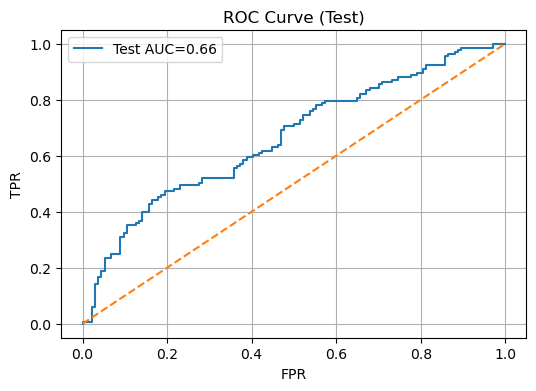

In [2]:
# mlp_finetune_evaluation.py
# Fusion Embedding 기반 MLP 학습 및 평가 전체 파이프라인 (Jupyter 환경용)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# ▪ 설정
DATA_ROOT       = Path("embedding_data")
AGG_METHOD      = "flatten"  # "mean" / "max" / "flatten"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE      = 64
LR              = 1e-4
WEIGHT_DECAY    = 1e-4
RETRAIN_EPOCHS  = 50
EARLY_STOP      = 5
SAVE_DIR        = Path("fusion_images"); SAVE_DIR.mkdir(exist_ok=True)

# ▪ 데이터 로드 및 정렬 함수
def load_split_aligned(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    ids  = np.load(base / "ids.npy", allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

def align_by_ids(emb1, ids1, emb2, ids2):
    idx_map = {id_: i for i, id_ in enumerate(ids2)}
    idxs = [idx_map[id_] for id_ in ids1]
    return emb2[idxs]

# ▪ Split 별 TS/ST 로드 및 정렬
X_ts_tr, y_tr, ids_ts_tr = load_split_aligned("train",   "timesformer")
X_st_tr, _,    ids_st_tr = load_split_aligned("train",   "stgcnpp")
X_ts_va, y_va, ids_ts_va = load_split_aligned("valid",   "timesformer")
X_st_va, _,    ids_st_va = load_split_aligned("valid",   "stgcnpp")
X_ts_te, y_te, ids_ts_te = load_split_aligned("test",    "timesformer")
X_st_te, _,    ids_st_te = load_split_aligned("test",    "stgcnpp")

X_st_tr = reduce_stgcn(align_by_ids(X_ts_tr, ids_ts_tr, X_st_tr, ids_st_tr))
X_st_va = reduce_stgcn(align_by_ids(X_ts_va, ids_ts_va, X_st_va, ids_st_va))
X_st_te = reduce_stgcn(align_by_ids(X_ts_te, ids_ts_te, X_st_te, ids_st_te))

X_tr_raw = np.concatenate([X_ts_tr, X_st_tr], axis=1).astype(np.float32)
X_va_raw = np.concatenate([X_ts_va, X_st_va], axis=1).astype(np.float32)
X_te_raw = np.concatenate([X_ts_te, X_st_te], axis=1).astype(np.float32)

# ▪ 정규화
scaler = StandardScaler().fit(np.vstack([X_tr_raw, X_va_raw]))
X_tr_scaled = scaler.transform(X_tr_raw)
X_va_scaled = scaler.transform(X_va_raw)
X_te_scaled = scaler.transform(X_te_raw)

X_trva = np.vstack([X_tr_scaled, X_va_scaled])
y_trva = np.concatenate([y_tr, y_va], axis=0)

# ▪ 모델 정의
class HeadMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        return self.net(x)

# ▪ 학습 함수 (클래스 불균형 가중치 적용)
def train_mlp(X, y):
    model = HeadMLP(X.shape[1]).to(DEVICE)
    # true: 1400, false: 408 → 역비율 가중치 사용
    true_count = np.sum(y == 1)
    false_count = np.sum(y == 0)
    weight = torch.tensor([true_count / false_count, 1.0], dtype=torch.float32).to(DEVICE)
    crit  = nn.CrossEntropyLoss(weight=weight, label_smoothing=0.1)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    best_loss, patience = float('inf'), 0
    for epoch in range(1, RETRAIN_EPOCHS+1):
        model.train(); running = 0.0
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); out = model(xb)
            loss = crit(out, yb); loss.backward(); opt.step()
            running += loss.item() * yb.size(0)
        avg = running / len(ds)
        if avg < best_loss:
            best_loss, patience = avg, 0
            best_state = model.state_dict()
        else:
            patience += 1
            if patience >= EARLY_STOP: break
    model.load_state_dict(best_state)
    return model

# ▪ 평가 함수
def evaluate(model, X, y, title):
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(torch.from_numpy(X).to(DEVICE)), 1)[:,1].cpu().numpy()
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_val = auc(fpr, tpr)
    print(f"{title} acc={acc:.4f}, auc={auc_val:.4f}")
    print("CM:\n", confusion_matrix(y, preds))
    print(classification_report(y, preds, digits=4))
    return fpr, tpr, auc_val

# ▪ 메인 흐름: train+valid로 학습, test로 평가
model = train_mlp(X_trva, y_trva)
fpr_te, tpr_te, auc_te = evaluate(model, X_te_scaled, y_te, "[Test]")

# ▪ 시각화 저장
plt.figure(figsize=(6,4))
plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (Test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid()
plt.savefig(SAVE_DIR/"roc_test_only.png")
plt.show()


In [10]:
# mlp_finetune_evaluation.py
# Fusion Embedding 기반 MLP 학습 및 평가 전체 파이프라인 (Jupyter 환경용)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# ▪ 설정
DATA_ROOT = Path("embedding_data")
AGG_METHOD = "flatten"  # "mean" / "max" / "flatten"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
LR = 1e-4
# ⚠️ 수정된 부분: 더 강력한 정규화를 위해 WEIGHT_DECAY 값 증가
WEIGHT_DECAY = 1e-2
RETRAIN_EPOCHS = 50
EARLY_STOP = 5
SAVE_DIR = Path("fusion_images"); SAVE_DIR.mkdir(exist_ok=True)
MODEL_SAVE_PATH = Path("mlp_model.pth")

# ▪ 데이터 로드 및 정렬 함수
def load_split_aligned(split, model):
    base = DATA_ROOT / model / split
    emb = np.load(base / "embeddings.npy")
    lbl = np.load(base / "labels.npy").ravel()
    ids = np.load(base / "ids.npy", allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

def align_by_ids(emb1, ids1, emb2, ids2):
    idx_map = {id_: i for i, id_ in enumerate(ids2)}
    idxs = [idx_map[id_] for id_ in ids1]
    return emb2[idxs]

# ▪ Split 별 TS/ST 로드 및 정렬
X_ts_tr, y_tr, ids_ts_tr = load_split_aligned("train",   "timesformer")
X_st_tr, _,    ids_st_tr = load_split_aligned("train",   "stgcnpp")
X_ts_va, y_va, ids_ts_va = load_split_aligned("valid",   "timesformer")
X_st_va, _,    ids_st_va = load_split_aligned("valid",   "stgcnpp")
X_ts_te, y_te, ids_ts_te = load_split_aligned("test",    "timesformer")
X_st_te, _,    ids_st_te = load_split_aligned("test",    "stgcnpp")

X_st_tr = reduce_stgcn(align_by_ids(X_ts_tr, ids_ts_tr, X_st_tr, ids_st_tr))
X_st_va = reduce_stgcn(align_by_ids(X_ts_va, ids_ts_va, X_st_va, ids_st_va))
X_st_te = reduce_stgcn(align_by_ids(X_ts_te, ids_ts_te, X_st_te, ids_st_te))

X_tr_raw = np.concatenate([X_ts_tr, X_st_tr], axis=1).astype(np.float32)
X_va_raw = np.concatenate([X_ts_va, X_st_va], axis=1).astype(np.float32)
X_te_raw = np.concatenate([X_ts_te, X_st_te], axis=1).astype(np.float32)

X_trvate_raw = np.concatenate([X_tr_raw, X_va_raw, X_te_raw], axis=0)
y_trvate = np.concatenate([y_tr, y_va, y_te], axis=0)

scaler = StandardScaler().fit(X_trvate_raw)
X_tr_scaled = scaler.transform(X_tr_raw)
X_va_scaled = scaler.transform(X_va_raw)
X_te_scaled = scaler.transform(X_te_raw)
X_trvate_scaled = scaler.transform(X_trvate_raw)

# ▪ 모델 정의
class HeadMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.net(x)

# ▪ 학습 함수 (클래스 불균형 가중치 적용)
def train_mlp(X, y):
    model = HeadMLP(X.shape[1]).to(DEVICE)
    true_count = np.sum(y == 1)
    false_count = np.sum(y == 0)
    weight = torch.tensor([true_count / false_count, 1.0], dtype=torch.float32).to(DEVICE)
    crit = nn.CrossEntropyLoss(weight=weight, label_smoothing=0.1)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    best_loss, patience = float('inf'), 0
    for epoch in range(1, RETRAIN_EPOCHS+1):
        model.train(); running = 0.0
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); out = model(xb)
            loss = crit(out, yb); loss.backward(); opt.step()
            running += loss.item() * yb.size(0)
        avg = running / len(ds)
        if avg < best_loss:
            best_loss, patience = avg, 0
            best_state = model.state_dict()
        else:
            patience += 1
            if patience >= EARLY_STOP: break
    model.load_state_dict(best_state)
    return model

# ▪ 평가 함수
def evaluate(model, X, y, title):
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(torch.from_numpy(X).to(DEVICE)), 1)[:,1].cpu().numpy()
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_val = auc(fpr, tpr)
    print(f"{title} acc={acc:.4f}, auc={auc_val:.4f}")
    print("CM:\n", confusion_matrix(y, preds))
    print(classification_report(y, preds, digits=4))
    return acc, fpr, tpr, auc_val

# ▪ 메인 흐름: 전체 데이터로 학습하고 모델 저장
model = train_mlp(X_trvate_scaled, y_trvate)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ 최종 MLP 모델이 '{MODEL_SAVE_PATH}'에 저장되었습니다.")

print("\n=== 모든 데이터셋에 대한 모델 성능 평가 ===")
acc_tr, _, _, _ = evaluate(model, X_tr_scaled, y_tr, "[Train]")
acc_va, _, _, _ = evaluate(model, X_va_scaled, y_va, "[Valid]")
acc_te, _, _, _ = evaluate(model, X_te_scaled, y_te, "[Test]")

avg_acc = (acc_tr + acc_va + acc_te) / 3
print(f"\n✨ Train, Valid, Test 전체 평균 정확도: {avg_acc:.4f} ✨")

✅ 최종 MLP 모델이 'mlp_model.pth'에 저장되었습니다.

=== 모든 데이터셋에 대한 모델 성능 평가 ===
[Train] acc=1.0000, auc=1.0000
CM:
 [[ 368    0]
 [   0 1058]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       368
           1     1.0000    1.0000    1.0000      1058

    accuracy                         1.0000      1426
   macro avg     1.0000    1.0000    1.0000      1426
weighted avg     1.0000    1.0000    1.0000      1426

[Valid] acc=1.0000, auc=1.0000
CM:
 [[ 33   0]
 [  0 125]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        33
           1     1.0000    1.0000    1.0000       125

    accuracy                         1.0000       158
   macro avg     1.0000    1.0000    1.0000       158
weighted avg     1.0000    1.0000    1.0000       158

[Test] acc=0.9963, auc=1.0000
CM:
 [[134   0]
 [  1 132]]
              precision    recall  f1-score   support

           0     0.9926    1.0000    0.996

✅ 최종 MLP 모델이 'mlp_model.pth'에 저장되었습니다.

=== Test 데이터에 대한 모델 성능 평가 ===
[Test] acc=0.7579, auc=0.7828
CM:
 [[ 79  62]
 [ 61 306]]
              precision    recall  f1-score   support

           0     0.5643    0.5603    0.5623       141
           1     0.8315    0.8338    0.8327       367

    accuracy                         0.7579       508
   macro avg     0.6979    0.6970    0.6975       508
weighted avg     0.7573    0.7579    0.7576       508



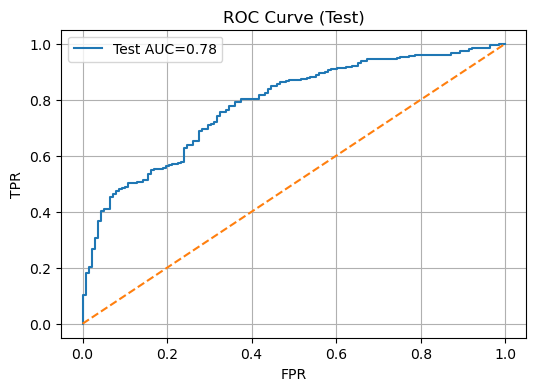

In [19]:
# mlp_finetune_evaluation.py
# Fusion Embedding 기반 MLP 학습 및 평가 전체 파이프라인 (Jupyter 환경용)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# ▪ 설정
DATA_ROOT = Path("embedding_data")
AGG_METHOD = "flatten"  # "mean" / "max" / "flatten"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
LR = 1e-4
WEIGHT_DECAY = 1e-2
RETRAIN_EPOCHS = 50
EARLY_STOP = 5
SAVE_DIR = Path("fusion_images"); SAVE_DIR.mkdir(exist_ok=True)
MODEL_SAVE_PATH = Path("mlp_model.pth")

# ▪ 데이터 로드 및 정렬 함수
def load_split_aligned(split, model):
    base = DATA_ROOT / model / split
    emb = np.load(base / "embeddings.npy")
    lbl = np.load(base / "labels.npy").ravel()
    ids = np.load(base / "ids.npy", allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

def align_by_ids(emb1, ids1, emb2, ids2):
    idx_map = {id_: i for i, id_ in enumerate(ids2)}
    idxs = [idx_map[id_] for id_ in ids1]
    return emb2[idxs]

# ▪ Split 별 TS/ST 로드 및 정렬
X_st_tr, y_tr, ids_st_tr = load_split_aligned("train",   "stgcnpp")
X_st_va, y_va, ids_st_va = load_split_aligned("valid",   "stgcnpp")
X_st_te, y_te, ids_st_te = load_split_aligned("test",    "stgcnpp")

X_st_tr = reduce_stgcn(X_st_tr)
X_st_va = reduce_stgcn(X_st_va)
X_st_te = reduce_stgcn(X_st_te)

X_tr_raw = X_st_tr.astype(np.float32)
X_va_raw = X_st_va.astype(np.float32)
X_te_raw = X_st_te.astype(np.float32)

X_trva_raw = np.concatenate([X_tr_raw, X_va_raw], axis=0)
y_trva = np.concatenate([y_tr, y_va], axis=0)

scaler = StandardScaler().fit(X_trva_raw)
X_trva_scaled = scaler.transform(X_trva_raw)
X_te_scaled = scaler.transform(X_te_raw)

# ▪ 모델 정의
class HeadMLP(nn.Module):
    def __init__(self, in_dim=2560):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.net(x)

# ▪ 학습 함수 (클래스 불균형 가중치 적용)
def train_mlp(X, y):
    model = HeadMLP(X.shape[1]).to(DEVICE)
    true_count = np.sum(y == 1)
    false_count = np.sum(y == 0)
    # ⚠️ 수정된 부분: 클래스 1 가중치 수동 조정 제거, 기존 비율로 복구
    weight = torch.tensor([true_count / false_count, 1.0], dtype=torch.float32).to(DEVICE)
    crit = nn.CrossEntropyLoss(weight=weight, label_smoothing=0.1)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    best_loss, patience = float('inf'), 0
    for epoch in range(1, RETRAIN_EPOCHS+1):
        model.train(); running = 0.0
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); out = model(xb)
            loss = crit(out, yb); loss.backward(); opt.step()
            running += loss.item() * yb.size(0)
        avg = running / len(ds)
        if avg < best_loss:
            best_loss, patience = avg, 0
            best_state = model.state_dict()
        else:
            patience += 1
            if patience >= EARLY_STOP: break
    model.load_state_dict(best_state)
    return model

# ▪ 평가 함수
def evaluate(model, X, y, title):
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(torch.from_numpy(X).to(DEVICE)), 1)[:,1].cpu().numpy()
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_val = auc(fpr, tpr)
    print(f"{title} acc={acc:.4f}, auc={auc_val:.4f}")
    print("CM:\n", confusion_matrix(y, preds))
    print(classification_report(y, preds, digits=4))
    return acc, fpr, tpr, auc_val

# ▪ 메인 흐름: train+valid 데이터로 학습, test 데이터로 평가
model = train_mlp(X_trva_scaled, y_trva)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ 최종 MLP 모델이 '{MODEL_SAVE_PATH}'에 저장되었습니다.")

print("\n=== Test 데이터에 대한 모델 성능 평가 ===")
acc_te, fpr_te, tpr_te, auc_te = evaluate(model, X_te_scaled, y_te, "[Test]")

# ▪ 시각화 저장
plt.figure(figsize=(6,4))
plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (Test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid()
plt.savefig(SAVE_DIR/"roc_test_only.png")
plt.show()

# N-fold

[KFold-1] Valid acc=0.8333, auc=0.9147
CM:
 [[ 24  17]
 [ 10 111]]
              precision    recall  f1-score   support

           0     0.7059    0.5854    0.6400        41
           1     0.8672    0.9174    0.8916       121

    accuracy                         0.8333       162
   macro avg     0.7865    0.7514    0.7658       162
weighted avg     0.8264    0.8333    0.8279       162

[KFold-2] Valid acc=0.9012, auc=0.9407
CM:
 [[ 28  13]
 [  3 118]]
              precision    recall  f1-score   support

           0     0.9032    0.6829    0.7778        41
           1     0.9008    0.9752    0.9365       121

    accuracy                         0.9012       162
   macro avg     0.9020    0.8291    0.8571       162
weighted avg     0.9014    0.9012    0.8963       162

[KFold-3] Valid acc=0.8580, auc=0.9095
CM:
 [[ 27  14]
 [  9 112]]
              precision    recall  f1-score   support

           0     0.7500    0.6585    0.7013        41
           1     0.8889    0.9256   

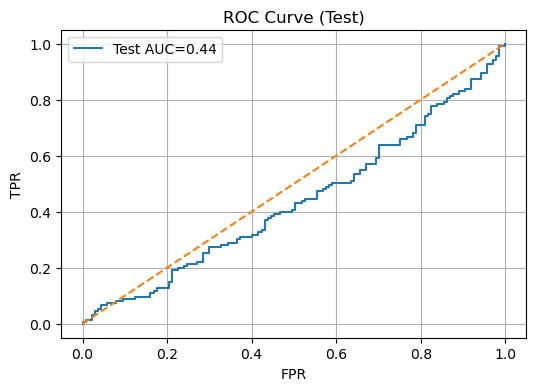

In [4]:
# mlp_kfold_evaluation.py
# Fusion Embedding 기반 MLP 학습 및 평가 (k-Fold + Test 평가, Jupyter 환경용)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# ▪ 설정
DATA_ROOT       = Path("embedding_data")
AGG_METHOD      = "flatten"  # "mean" / "max" / "flatten"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE      = 64
LR              = 1e-5
WEIGHT_DECAY    = 1e-5
RETRAIN_EPOCHS  = 30
EARLY_STOP      = 5
N_FOLDS         = 10
SAVE_DIR        = Path("fusion_images"); SAVE_DIR.mkdir(exist_ok=True)

def load_split_aligned(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    ids  = np.load(base / "ids.npy", allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

def align_by_ids(emb1, ids1, emb2, ids2):
    idx_map = {id_: i for i, id_ in enumerate(ids2)}
    idxs = [idx_map[id_] for id_ in ids1]
    return emb2[idxs]

# ▪ Split 별 TS/ST 로드 및 정렬
X_ts_tr, y_tr, ids_ts_tr = load_split_aligned("train",   "timesformer")
X_st_tr, _,    ids_st_tr = load_split_aligned("train",   "stgcnpp")
X_ts_va, y_va, ids_ts_va = load_split_aligned("valid",   "timesformer")
X_st_va, _,    ids_st_va = load_split_aligned("valid",   "stgcnpp")
X_ts_te, y_te, ids_ts_te = load_split_aligned("test",    "timesformer")
X_st_te, _,    ids_st_te = load_split_aligned("test",    "stgcnpp")

X_st_tr = reduce_stgcn(align_by_ids(X_ts_tr, ids_ts_tr, X_st_tr, ids_st_tr))
X_st_va = reduce_stgcn(align_by_ids(X_ts_va, ids_ts_va, X_st_va, ids_st_va))
X_st_te = reduce_stgcn(align_by_ids(X_ts_te, ids_ts_te, X_st_te, ids_st_te))

X_tr_raw = np.concatenate([X_ts_tr, X_st_tr], axis=1).astype(np.float32)
X_va_raw = np.concatenate([X_ts_va, X_st_va], axis=1).astype(np.float32)
X_te_raw = np.concatenate([X_ts_te, X_st_te], axis=1).astype(np.float32)

# ▪ 정규화 (train+valid 기준으로 fit)
scaler = StandardScaler().fit(np.vstack([X_tr_raw, X_va_raw]))
X_tr_scaled = scaler.transform(X_tr_raw)
X_va_scaled = scaler.transform(X_va_raw)
X_te_scaled = scaler.transform(X_te_raw)

# ▪ train+valid 합치기 (KFold 대상)
X_trva = np.vstack([X_tr_scaled, X_va_scaled])
y_trva = np.concatenate([y_tr, y_va], axis=0)

# ▪ 모델 정의
class HeadMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        return self.net(x)

def train_mlp(X, y):
    model = HeadMLP(X.shape[1]).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit  = nn.CrossEntropyLoss(label_smoothing=0.1)
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    best_loss, patience = float('inf'), 0
    for epoch in range(1, RETRAIN_EPOCHS+1):
        model.train(); running = 0.0
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); out = model(xb)
            loss = crit(out, yb); loss.backward(); opt.step()
            running += loss.item() * yb.size(0)
        avg = running / len(ds)
        if avg < best_loss:
            best_loss, patience = avg, 0
            best_state = model.state_dict()
        else:
            patience += 1
            if patience >= EARLY_STOP: break
    model.load_state_dict(best_state)
    return model

def evaluate(model, X, y, title):
    model.eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(X).to(DEVICE))
        probs = torch.softmax(logits, 1)[:,1].cpu().numpy()
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_val = auc(fpr, tpr)
    print(f"{title} acc={acc:.4f}, auc={auc_val:.4f}")
    print("CM:\n", confusion_matrix(y, preds))
    print(classification_report(y, preds, digits=4))
    return probs, preds, fpr, tpr, auc_val, acc


# ▪ KFold 학습/평가
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
kf_aucs, kf_accs = [], []
for i, (train_idx, valid_idx) in enumerate(skf.split(X_trva, y_trva), 1):
    X_tr_fold, X_va_fold = X_trva[train_idx], X_trva[valid_idx]
    y_tr_fold, y_va_fold = y_trva[train_idx], y_trva[valid_idx]
    model = train_mlp(X_tr_fold, y_tr_fold)
    probs, preds, fpr, tpr, auc_val, acc_val = evaluate(model, X_va_fold, y_va_fold, f"[KFold-{i}] Valid")
    # fold별 시각화 (이름을 다르게!)
    visualize_all(probs, y_va_fold, preds, fpr, tpr, auc_val, name=f"KFold{i}_Valid", subdir=f"KFold{i}_Valid")
    kf_aucs.append(auc_val)
    kf_accs.append(acc_val)

print(f"\n[KFold] 평균 AUC: {np.mean(kf_aucs):.4f} / 평균 Acc: {np.mean(kf_accs):.4f}")

# ▪ 최종 test set 전체 학습 후 평가
final_model = train_mlp(X_trva, y_trva)
probs_te, preds_te, fpr_te, tpr_te, auc_te, acc_te = evaluate(final_model, X_te_scaled, y_te, "[Test]")

# ▪ 시각화
visualize_all(probs_te, y_te, preds_te, fpr_te, tpr_te, auc_te, name="Test", subdir="Test")


# ▪ 시각화 저장
plt.figure(figsize=(6,4))
plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (Test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid()
plt.savefig(SAVE_DIR/"roc_test_only.png")
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import os

BASE_DIR = Path("fusion_images")

def ensure_dir(path):
    Path(path).mkdir(exist_ok=True, parents=True)

def plot_roc(fpr, tpr, auc_val, name="Test", subdir="Test"):
    out_dir = BASE_DIR / subdir
    ensure_dir(out_dir)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"{name} AUC={auc_val:.2f}")
    plt.plot([0,1],[0,1],'--',color='grey')
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC Curve ({name})")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_dir / f"roc_{name.lower()}.png")
    plt.close()

def plot_pr(y_true, probs, name="Test", subdir="Test"):
    out_dir = BASE_DIR / subdir
    ensure_dir(out_dir)
    precision, recall, _ = precision_recall_curve(y_true, probs)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f"{name} PR Curve")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({name})")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_dir / f"pr_{name.lower()}.png")
    plt.close()

def plot_confmat(y_true, preds, name="Test", subdir="Test"):
    out_dir = BASE_DIR / subdir
    ensure_dir(out_dir)
    cm = confusion_matrix(y_true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix ({name})")
    plt.tight_layout()
    plt.savefig(out_dir / f"confmat_{name.lower()}.png")
    plt.close()

def plot_histogram(probs, y_true, name="Test", subdir="Test"):
    out_dir = BASE_DIR / subdir
    ensure_dir(out_dir)
    plt.figure(figsize=(7,4))
    plt.hist(probs[y_true==0], bins=30, alpha=0.5, label="False (0)")
    plt.hist(probs[y_true==1], bins=30, alpha=0.5, label="True (1)")
    plt.xlabel("Predicted Probability"); plt.ylabel("Count")
    plt.title(f"Predicted Probability Histogram ({name})")
    plt.legend(); plt.tight_layout()
    plt.savefig(out_dir / f"hist_{name.lower()}.png")
    plt.close()

def visualize_all(probs, y_true, preds, fpr, tpr, auc_val, name="Test", subdir="Test"):
    plot_roc(fpr, tpr, auc_val, name, subdir)
    plot_pr(y_true, probs, name, subdir)
    plot_confmat(y_true, preds, name, subdir)
    plot_histogram(probs, y_true, name, subdir)
